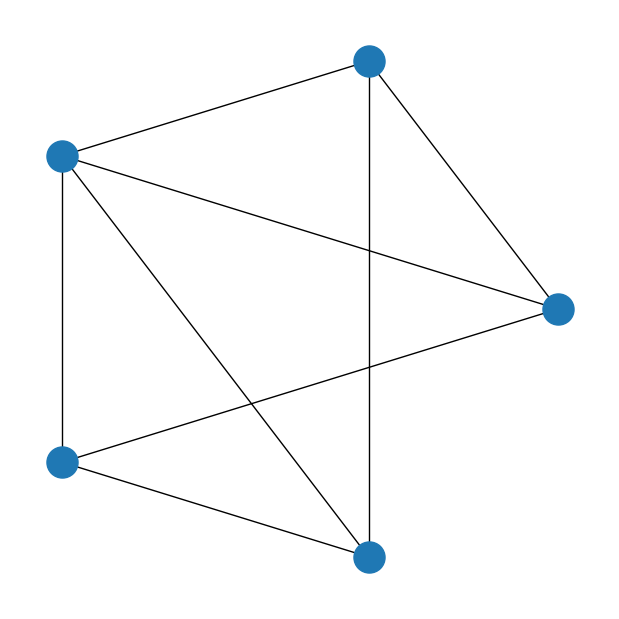

In [ ]:
import numpy as np
from itertools import permutations
from src.viz import simple_graph_from_adj, generate_sbm, plot_sbm, MySbmFromScratch
import networkx as nx
import torch
from itertools import permutations
from tqdm import trange
import matplotlib.pyplot as plt

matrix = np.array([[0,1,1,1,0],
                  [1,0,1,0,1],
                  [1,1,0,1,1],
                  [1,0,1,0,1],
                  [0,1,1,1,0]])

simple_graph_from_adj(matrix, labels=False)

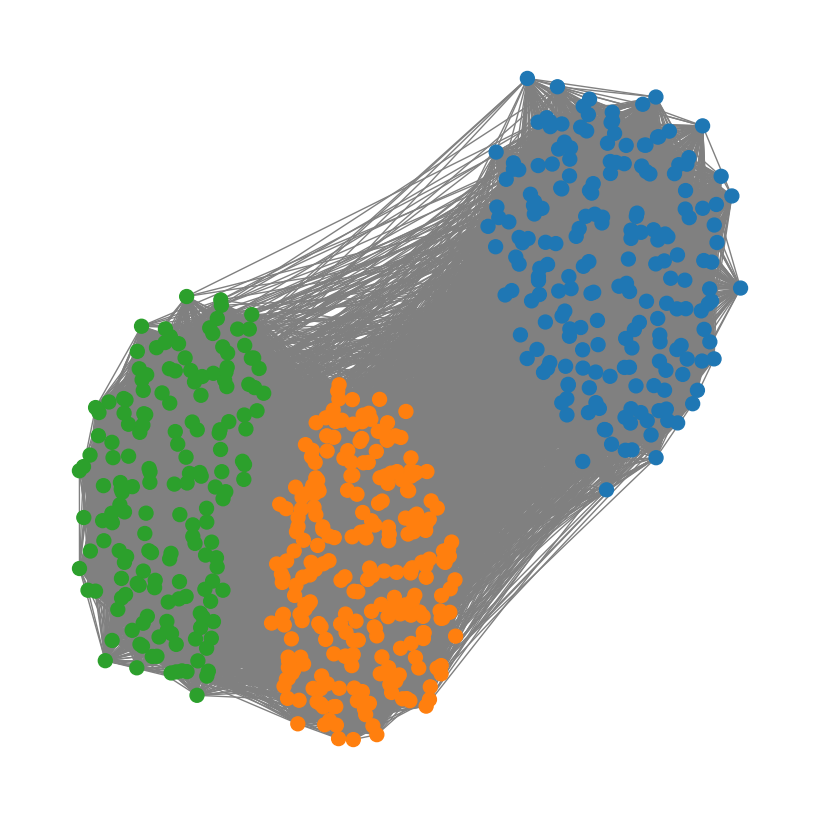

In [149]:
n_classes = [200, 250, 170]

probs = np.array([
    [0.4, 0.03, 0.01],
    [0.03, 0.5, 0.1],
    [0.01, 0.1, 0.4]
])

G = generate_sbm(n_classes, probs)

plot_sbm(G, n_classes)


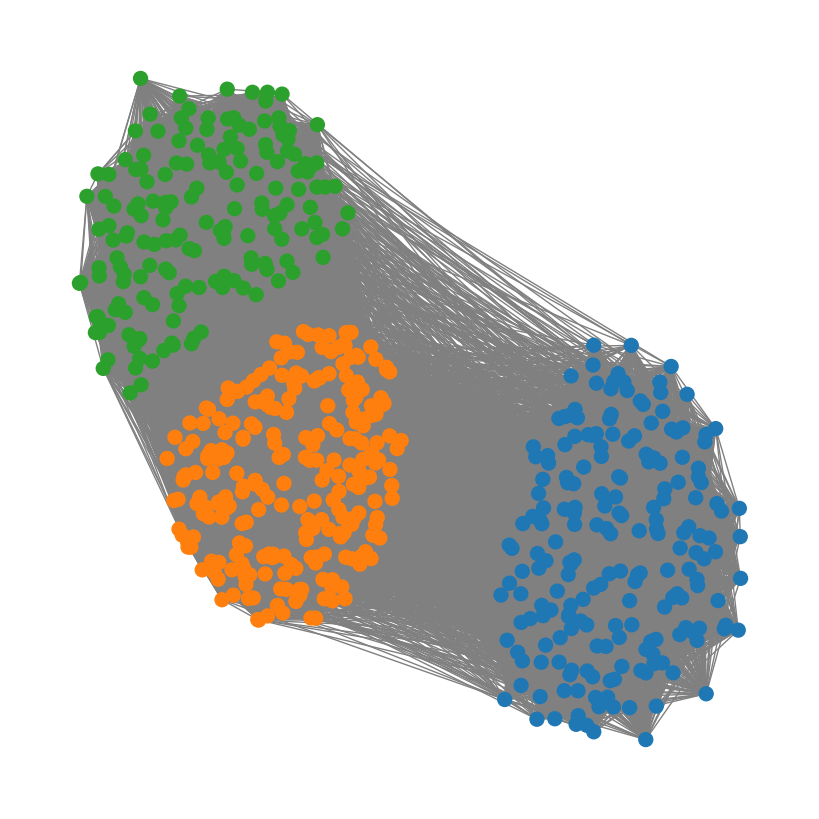

In [150]:
sbm = MySbmFromScratch()

sbm.generate_graph(n_classes = n_classes, probs = probs)
sbm.plot_graph()


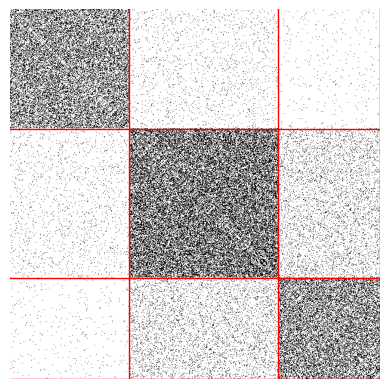

In [151]:
sbm.plot_adj()

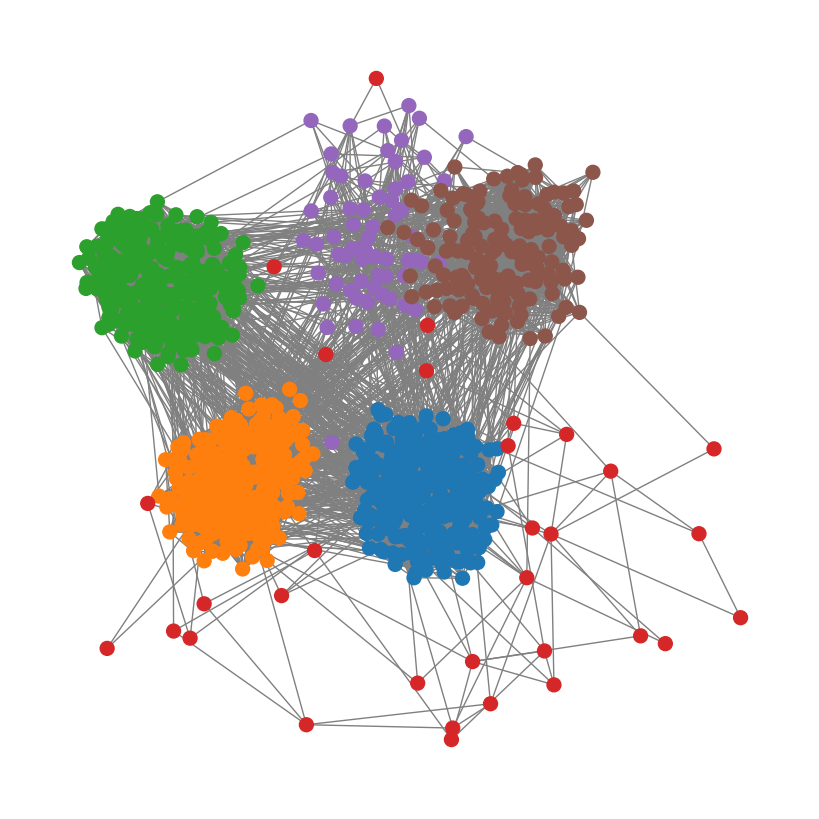

In [76]:
sbm = MySbmFromScratch()

sbm.generate_graph(N = 1000, K=6, _lambda=0.1, multiplier=0.08, alpha=1.5)
sbm.plot_graph()


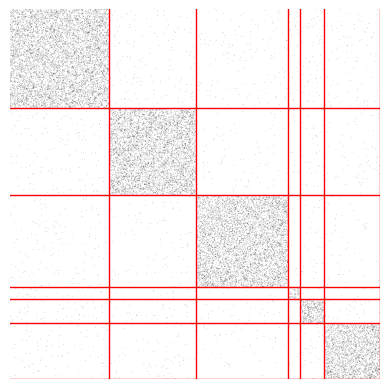

In [108]:
sbm.plot_adj()

In [7]:
from tqdm import trange

In [ ]:
class MixtureModel():
    def __init__(self, X, n, k, device='cpu'):
        self.device = torch.device(device)
        self.N = n
        self.K = k
        self.logs_like = []
        self.X = torch.tensor(X, dtype=torch.float, device=self.device)

        tau = torch.rand(n, k, device=self.device)
        tau /= tau.sum(dim=1, keepdim=True)
        self.tau = tau

    def comp_alpha_pi(self):
        mask = 1 - torch.eye(self.N, device=self.device)  # Diagonal mask to exclude self-loops

        numerator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, self.X * mask)
        denominator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, mask.float())

        pi = numerator / denominator
        alpha = self.tau.mean(dim=0)   

        return alpha, pi  # (K), (KxK)

    def compute_tau(self, alpha, pi, tau, epsilon=1e-10):
        N, K = tau.size()

        pi = torch.clamp(pi, min=epsilon, max=1 - epsilon)
        
        X_expanded = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        pi_expanded = pi.unsqueeze(0).unsqueeze(0)  # (1, 1, K, K)

        log_b = X_expanded * torch.log(pi_expanded) + (1 - X_expanded) * torch.log(1 - pi_expanded)

        tau_expanded = tau.unsqueeze(0).unsqueeze(-1)  # (1, N, K, 1)
        log_b_tau = log_b * tau_expanded  # (N, N, K, K)

        mask = 1 - torch.eye(N, device=self.device).unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        masked_log_b_tau = log_b_tau * mask

        sum_jl = torch.einsum('ijnq->iq', masked_log_b_tau)  # (N, K)

        log_alpha = torch.log(alpha + epsilon).unsqueeze(0)  # (1, K)
        log_tau = log_alpha + sum_jl
        log_tau = log_tau - log_tau.logsumexp(dim=1, keepdim=True)  # Normalization in log-space

        tau_new = torch.exp(log_tau)  # Back to probability space
        
        return tau_new

    def _likelihood(self, alpha, pi, tau):
        term1 = torch.einsum('iq,q->', tau, torch.log(alpha))

        X_unsqueezed = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        log_b = (
            X_unsqueezed * torch.log(pi) + (1 - X_unsqueezed) * torch.log(1 - pi)
        )
        term2 = 0.5 * torch.einsum('iq,jl,ijql->', tau, tau, log_b)

        epsilon = 1e-10
        term3 = -torch.einsum('iq,iq->', tau, torch.log(tau + epsilon))

        result = term1 + term2 + term3
        return result

    def _fixed_point_algorithm(self, alpha, pi, tau_initial, tol=1e-6, max_iter=100):
        tau = tau_initial.clone()
        for i in range(max_iter):
            tau_new = self.compute_tau(alpha, pi, tau)
            diff = torch.norm(tau_new - tau, p='fro')
            if diff < tol:
                break
            tau = tau_new

        return tau

    def em(self, max_it=50, tolerance=1e-10):
        prev_value = -float('inf')
        for _ in trange(max_it):
            alpha, pi = self.comp_alpha_pi()  # M step
            self.tau = self._fixed_point_algorithm(alpha, pi, self.tau)  # E step
            likeli = self._likelihood(alpha, pi, self.tau)  # Compute likelihood
            self.logs_like.append(likeli.item())
            if abs(likeli - prev_value) < tolerance:
                break
            prev_value = likeli

        return alpha.cpu().numpy(), pi.cpu().numpy(), self.tau

    def _ICL(self, Q, init=True):
        if init:
            self.__init__(self.X.cpu().numpy(), self.N, Q, device=self.device)
            self.em()
        tau = self.tau
        alpha, pi = self.comp_alpha_pi()
        n = self.N
        term = (1 / 4) * Q * (Q + 1) * np.log((n * (n - 1)) / 2) + ((Q - 1) / 2) * np.log(n)
        return self._likelihood(alpha, pi, tau).item() - term

    def discrete_distribution(self, x):
        cum_dist = torch.tensor(x.cumsum(0), dtype=torch.float)
        rand_val = np.random.rand()
        return torch.searchsorted(cum_dist, rand_val).item()

    def plot_from_tau(self, determinist=True):
        G = nx.from_numpy_array(self.X.cpu().numpy().astype(int))
        tau = self.tau.cpu().numpy()
        classes = [i for i in range(self.K)]
        for i, x in enumerate(tau):
            G.nodes[i]['cluster'] = np.argmax(x) if determinist else self.discrete_distribution(x)
        colors = {classe: plt.cm.tab10(i) for i, classe in enumerate(classes)}
        node_colors = [colors[G.nodes[i]['cluster']] for i in range(len(tau))]
        pos = nx.spring_layout(G)  
        plt.figure(figsize=(8, 6))        
        nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, font_size=15, font_weight='bold', edge_color='gray')
        plt.show()

    def loss(self, G, determinist = True):
        #if determinist : return the number of mismatch
        #else : return the sum of 1 - the probability of correct match 
        perm = list(permutations([i for i in range(self.K)]))
        minS = self.N
        minp = perm[0]
        
        for p in list(perm): 
            S = 0
            if determinist:
                for i, x in enumerate(self.tau):
                    if np.argmax(x.cpu()) != p[G.nodes[i]['block']]:
                        S += 1
            else:
                for i, x in enumerate(self.tau):
                    S += (1-x[p[G.nodes[i]['block']]])
            minS = min(S,minS)
            minp = p
            
        return minS


    def plot_preds_adjancy(self, adj):
        """
        Visualise une matrice d'adjacence regroupée selon les classes des prédites.

        adj (np.ndarray) : La matrice d'agency carrée (N x N).

        """

        classes = np.array(self.tau.argmax(dim=1).cpu())

        sorted_indices = np.argsort(classes)

        adj_sorted = adj[np.ix_(sorted_indices, sorted_indices)]

        unique_classes, counts = np.unique(classes, return_counts=True)
        cumulative_indices = np.cumsum(counts)

        plt.figure(figsize=(8, 8))
        plt.imshow(-adj_sorted, cmap="gray", extent=(0, adj.shape[1], adj.shape[0], 0))
        plt.axis("off")

        for index in cumulative_indices:
            plt.axhline(y=index, color='red', linestyle='-', linewidth=1)
            plt.axvline(x=index, color='red', linestyle='-', linewidth=1)

        plt.show()



test = MixtureModel(sbm.adj, sbm.adj.shape[0], 3, device='cuda')
_, __, tau = test.em()


 12%|█▏        | 6/50 [00:00<00:02, 16.62it/s]


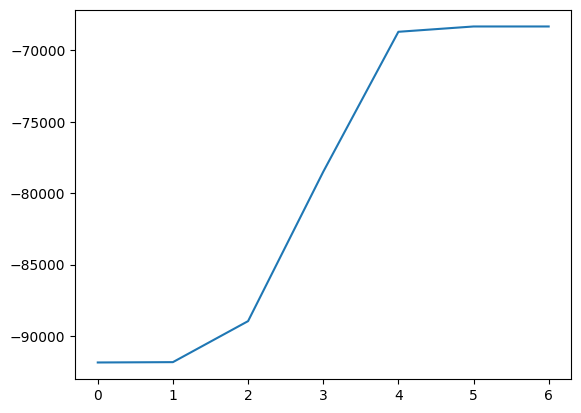

In [153]:
plt.plot(test.logs_like)
plt.show()

In [154]:
probs

array([[0.4 , 0.03, 0.01],
       [0.03, 0.5 , 0.1 ],
       [0.01, 0.1 , 0.4 ]])

In [155]:
__

array([[0.40334144, 0.01005882, 0.10181177],
       [0.01005882, 0.39743719, 0.03124   ],
       [0.10181177, 0.03124   , 0.49760643]], dtype=float32)

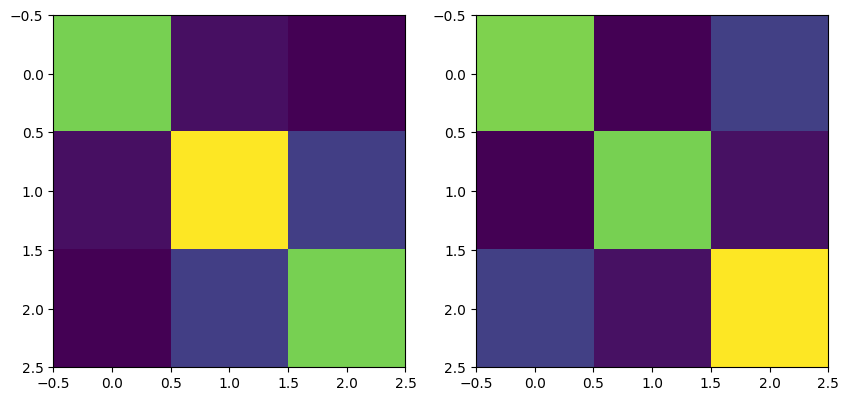

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(probs)
axes[1].imshow(__)

/tmp/ipykernel_4930/1199093152.py:154: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  classes = np.array(self.tau.argmax(dim=1).cpu())


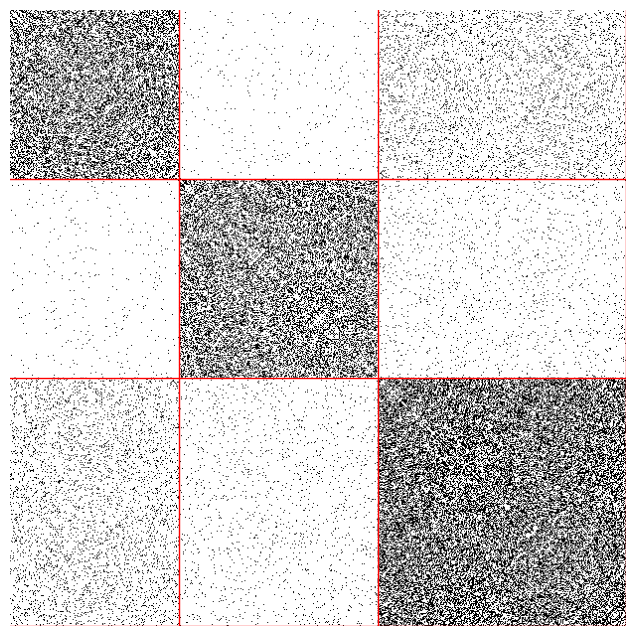

In [157]:
test.plot_preds_adjancy(sbm.adj)

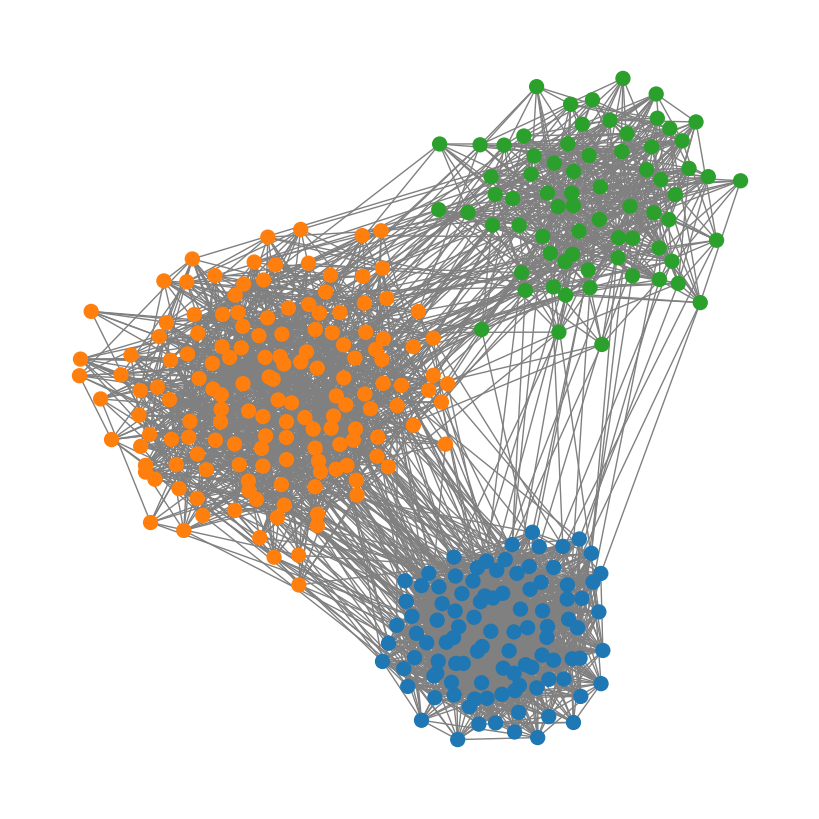

In [158]:
from src.viz import get_adjancy

n_classes = [100, 150, 70]

probs = np.array([
    [0.25, 0.01, 0.005],
    [0.01, 0.10, 0.009],
    [0.005, 0.009, 0.2]
])

G3 = generate_sbm(n_classes, probs)

M_3 = get_adjancy(G3.edges, len(G3.nodes))

plot_sbm(G3, n_classes)

 80%|████████  | 40/50 [00:07<00:01,  5.51it/s]


0


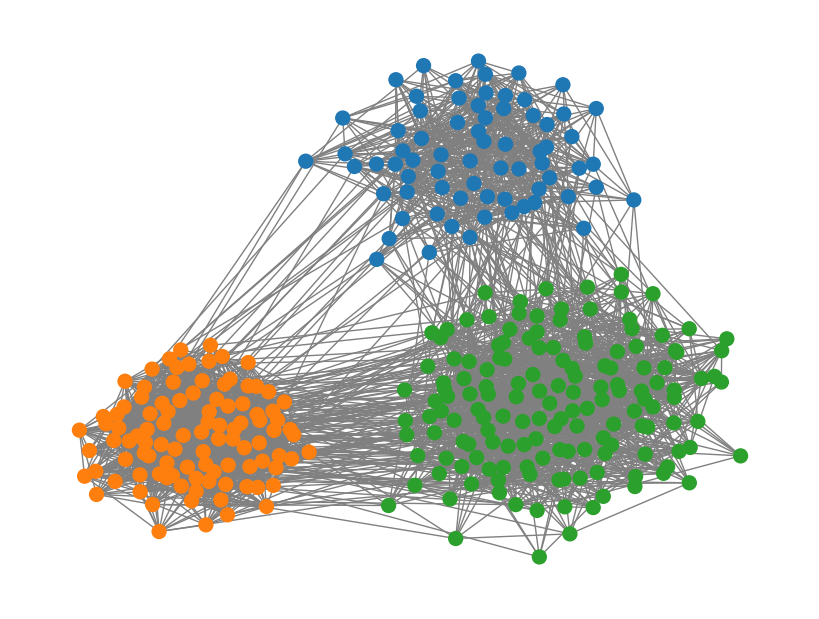

In [159]:
model3 = MixtureModel(M_3, 320, 3)
model3.em()
print(model3.loss(G3, determinist = True))
model3.plot_from_tau()

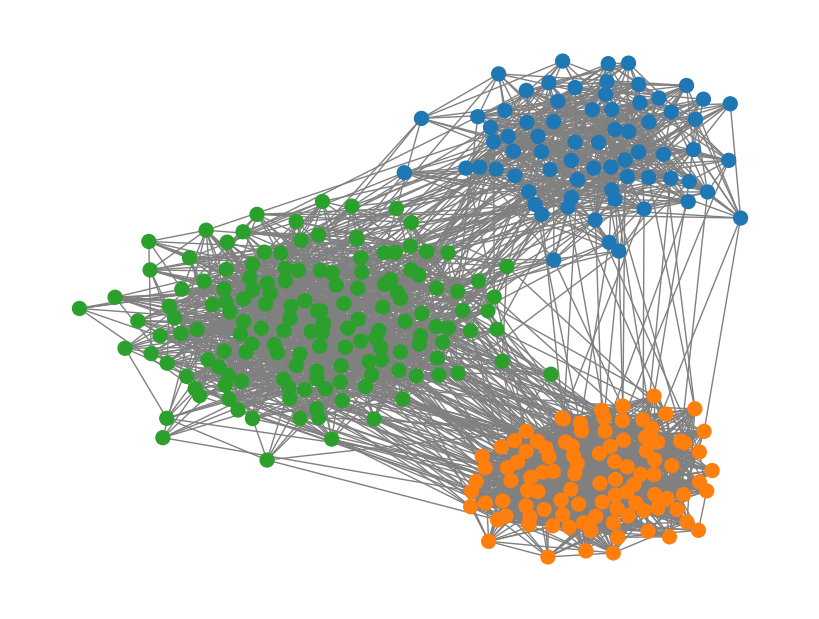

In [160]:
model3.plot_from_tau(determinist=False)

/tmp/ipykernel_4930/1199093152.py:154: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  classes = np.array(self.tau.argmax(dim=1).cpu())


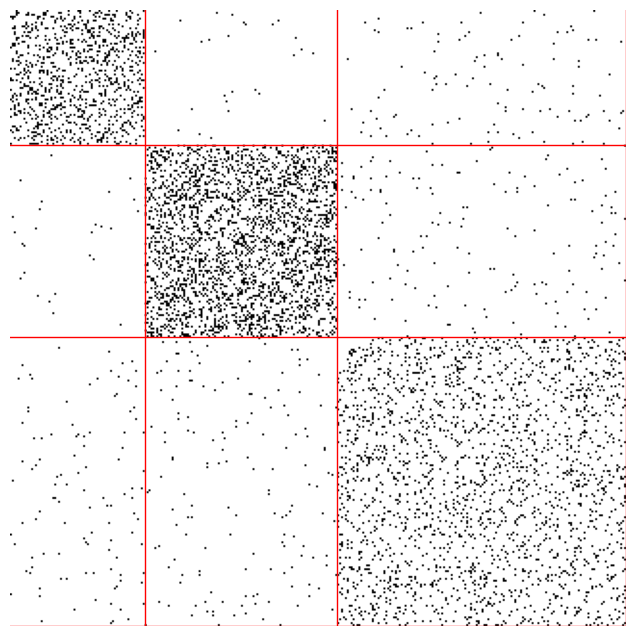

In [162]:
model3.plot_preds_adjancy(M_3)